# Predicting Blue-Chip Company Financial Trajectory

### COMS W4995 – Applied Machine Learning

#### **Group 24**: Yu-Heng Chi, Param Sejpal, Jessica Villanueva, Yihan Yang, Zhiyi Zhang

#### **UNI IDs**: yc4548, pns2129, jss2326, yy3528, zz3274

---


### Objective
Our objective is to measure a company’s financial health trajectory indicated by the equity value of the company. This means predicting the annual market capitalization ("Market Cap") using annual data (e.g., year-end market cap for 2025). The financial metrics we used are from a 2024 dataset for Fortune 1000 companies, and additional financial metrics we worked with are from 10-K reports found on the SEC database (More information on data sources is in the README.md and project deliverables).

In this project, we will:

1. **Regression**: Predicting the annual market cap using annual data (e.g., year-end market cap for 2025). The financial metrics we use include revenue, profits, EBITDA, and other key indicators.
2. **Classification**: Classifying companies as **growth** or **non-growth** based on financial health metrics like EBITDA margins.

In [575]:
# Imports

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2


In [576]:
# Load data
initial_df = pd.read_csv('data/FinancialData.csv')
initial_df.head()

,Company,Sector,Industry,Profitable,Number_of_employees,MarketCap_March28_M,Revenues_M,RevenuePercentChange,Profits_M,ProfitsPercentChange,Assets_M,CompanyType,MarketCap_Updated_M,EBITDA,EBITDA_Margin
0,Walmart,Retailing,General Merchandisers,yes,2100000,484852.8,648125.0,6.0,15511.0,32.8,252399.0,Public,559911.0,3.638400e+10,56137.319190
1,Amazon,Retailing,Internet Services and Retailing,yes,1525000,1873675.8,574785.0,11.8,30425.0,NaN,527854.0,Public,2005565.0,1.134840e+11,197437.302644
2,Apple,Technology,"Computers, Office Equipment",yes,161000,2647973.8,383285.0,-2.8,96995.0,-2.8,352583.0,Public,3594309.0,1.346610e+11,351333.863835
3,UnitedHealth Group,Health Care,Health Care: Insurance and Managed Care,yes,440000,456080.8,371622.0,14.6,22381.0,11.2,273720.0,Public,474339.0,2.790400e+10,75087.050820
4,Berkshire Hathaway,Financials,Insurance: Property and Casualty (Stock),yes,396500,908919.7,364482.0,20.7,96223.0,NaN,1069978.0,Public,937028.0,NaN,0.000000


# I. Preparing the data
We will analyze and visualize `FinancialData.csv`, inlcuding handling missing data, investigating and handling class imbalance, post-processing, and other data preparation methods.


Our **target** variable that we are aiming to predict is Market Cap. We have the following features that are relevant for predicting this variable:

1. Metrics describing *revenue* (e.g., Revenues_M, RevenuePercentChange).
2. Metrics describing *profit and earnings* (e.g., Profits_M, ProfitsPercentChange, EBITDA).
3. Metrics describing *company* assets (e.g., Assets_M).

*Note*: As we can already tell, some metrics may introduce multicollinearity into the dataset. 

The other features (Worlds_Most_Admired_Companies, Best_Companies_to_Work_For, and other features) are generally irrelevant for predicting financial metrics like Market Cap. In `generate.py`, we removed these irrelevant columsns to create a dataset with only relevant features. Next, we will handle missing values and correlated features.

### **Part 1: Data analaysis, visualization, and summarization**


In [577]:
initial_df = initial_df.dropna(subset=['MarketCap_March28_M'])
initial_df = initial_df.drop(columns=['Company'])

**1.1 Create bar plot comparing Market Cap by Industry and Company Type**

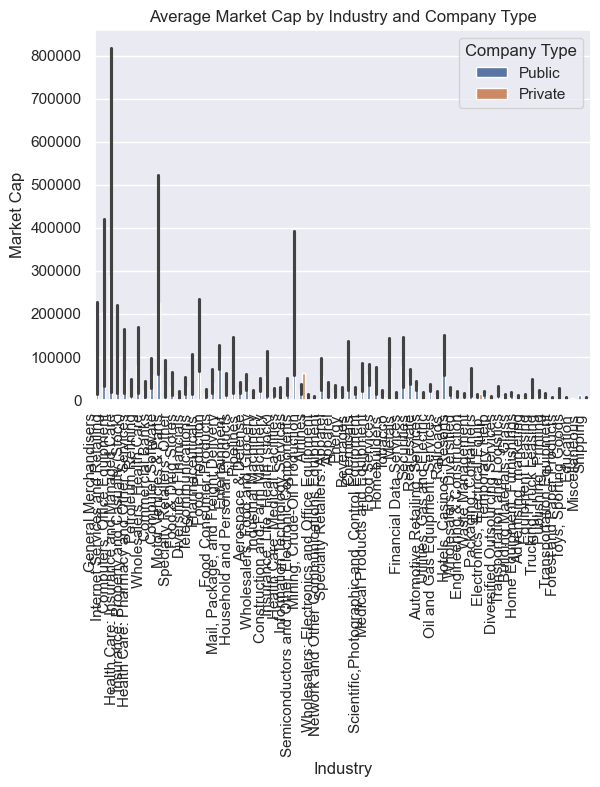

In [578]:
sns.barplot(initial_df, x="Industry", y="MarketCap_March28_M", hue="CompanyType")

# Labels
plt.title(f"Average Market Cap by Industry and Company Type")
plt.xlabel("Industry")
plt.ylabel("Market Cap")
plt.xticks(rotation=90, ha="right")
plt.legend(title='Company Type')

plt.show()

**1.2 Visualize data distributions for categorical variables**

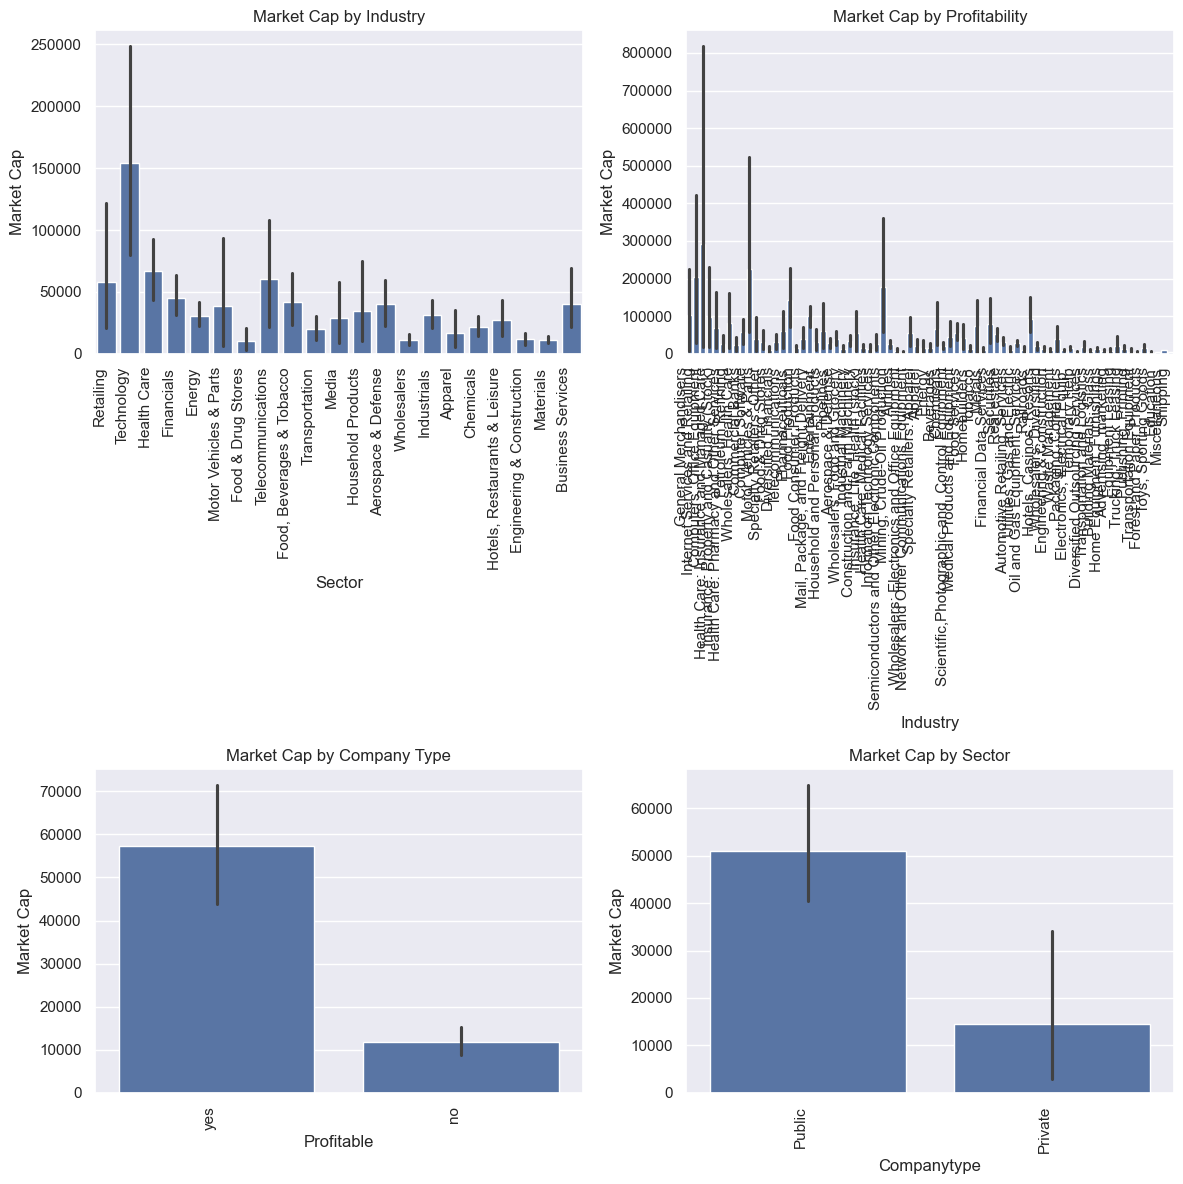

In [579]:
categorical_variables = ["Sector", "Industry", "Profitable", "CompanyType"]


fig, ax = plt.subplots(2, 2, figsize=(12, 12))

subplot_titles = {
    "Market Cap by Sector", 
    "Market Cap by Industry", 
    "Market Cap by Profitability",
    "Market Cap by Company Type",

}

for var, title, subplot in zip(categorical_variables, subplot_titles, ax.flatten()):
    sns.barplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    subplot.set_xlabel(var.capitalize())
    subplot.set_ylabel("Market Cap")
    subplot.set_title(title)
    plt.setp(subplot.xaxis.get_majorticklabels(), rotation=90, ha="right")

plt.tight_layout()
plt.show()

**1.3 Compare the Market Cap by Revenue and EBITDA. Create a Scatter plot for Revenue vs Market Cap categorized by Profitability.**

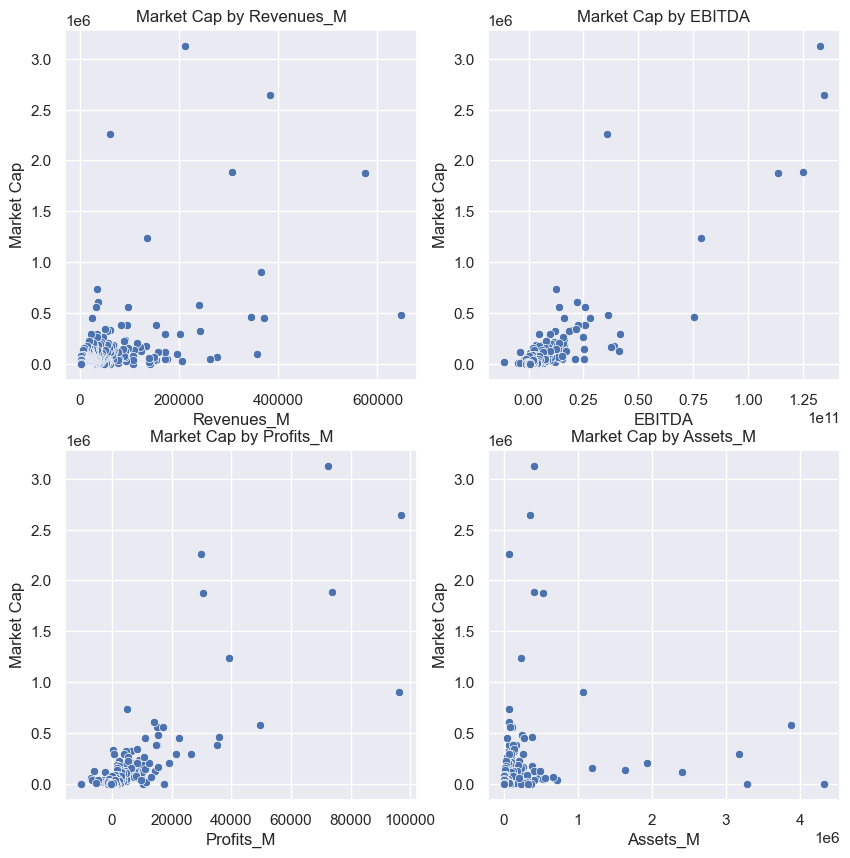

In [580]:
# Plot scatter plots for numerical features vs. Market Cap
num_features = ["Revenues_M", "EBITDA", "Profits_M", "Assets_M"]

fig, ax = plt.subplots(2,2, figsize=(10,10))

for var, subplot in zip(num_features, ax.flatten()):
    sns.scatterplot(x=var, y="MarketCap_March28_M", data=initial_df, ax=subplot)
    
    # Labels
    subplot.set_xlabel(var)
    subplot.set_ylabel("Market Cap")
    subplot.set_title(f"Market Cap by {var}")

plt.show()

### **Part 2: Data Preprocessing**


Financial data is typically imbalanced, and, as we saw in our results above, much of the data is skewed. Before we can fit a linear regression model, several pre-processing steps should be applied to the dataset:
 
1. **Encode categorical features** (e.g., `Sector`, `Industry`, `CompanyType`).
2. **Handle multicollinearity** (remove highly correlated features).
3. **Split the dataset** into training, validation, and test sets.
4. **Handle outliers and scale the numerical features** to handle skewed data.
 

### Multicollinearity

Checking for high correlation is important because linear regression assumes independence, and it is difficult to ascertain a linear relationship between features with multilinearity. Dropping one category of each encoded variable is necessary before proceeding further to avoid collinear columns, which will result in a singular matrix. These matrices are not invertible, and therefore collinear columns affect if we can apply the closed form solution. It is also much easier to train the model after dropping the features with high correlations from the dataframe. 

**2.2 Plot the correlation matrix and drop highly correlated features.**

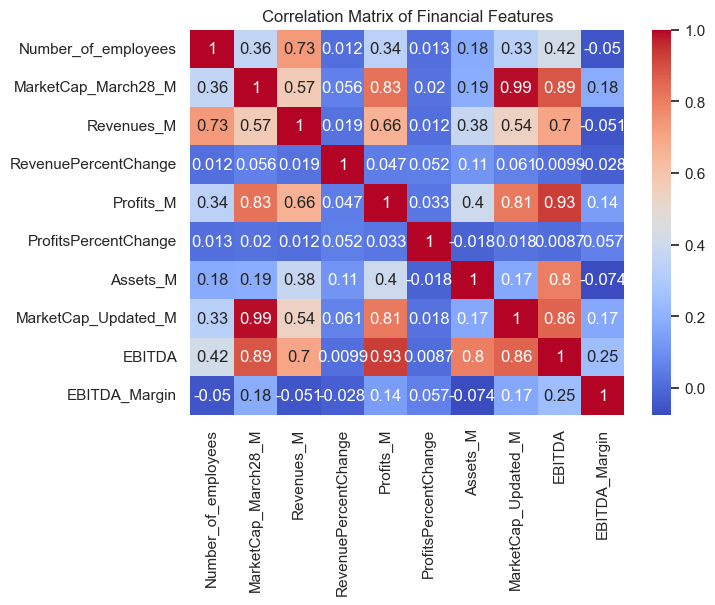

In [581]:
## Create correlation matrix

df_numeric = initial_df.select_dtypes(include=[np.number]) #TODO: make num_features
corr_matrix = df_numeric.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix of Financial Features')
plt.show()

**We will process the data by handling missing data, encoding the categorical variables, and applying standardization.**

We handled missing data by imputing the median. Additionally, in creating the dataset, we impute different values for EBITDA values that are missing (e.g., we imputed the LTM calculation into the cells with missing values). Note: we also dropped "EBITDA" because of its correlation with "EBITDA_Margins", where EBITDA margins were determined to be more important for our objective than the raw EBITDA values. 

In [582]:
# Handle missing values (we use `SimpleImputer()`` to impute the median – especially because of the skewed natre of our data)

imputer = SimpleImputer(strategy='median')
numeric_columns = initial_df.select_dtypes(include=[np.number]).columns
initial_df[numeric_columns] = imputer.fit_transform(initial_df[numeric_columns])

In [583]:
# Encode categorical features
encoded_df = pd.get_dummies(initial_df, columns=["Sector", "Industry", "CompanyType", "Profitable"], drop_first=True)

In [584]:
# Dropping highly correlated features

dropped = ['MarketCap_Updated_M', 'Profits_M', 'Number_of_employees'] 
df = encoded_df.drop(columns=dropped)

**Explanation of feature correlation**

Profits can oftentimes be proportional to Market Cap which explains the correlation between the variables. If a company is generating more profit, investors are more likely to want to invest in the company. These companies that are generating high profits will likely have more investors and consequently higher market cap.

**Cap Outliers for Key Features**

In [585]:
# We have really skewed data 


# Pandas .quantile()
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
upper_limit = df['MarketCap_March28_M'].quantile(0.99)
lower_limit = df['MarketCap_March28_M'].quantile(0.01)

# NumPy clip()
# https://numpy.org/doc/2.1/reference/generated/numpy.clip.html 
df['MarketCap_March28_M'] = np.clip(df['MarketCap_March28_M'], lower_limit, upper_limit)

for col in ['Revenues_M', 'Assets_M', 'EBITDA']:

    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)

    df[col] = np.clip(df[col], lower_limit, upper_limit)

In [586]:
# Prepare data for training

X = df.drop(columns=['MarketCap_March28_M'])  
y = df['MarketCap_March28_M'] 

### Dataset Split

**Split the dataset into training (60%), validation (20%), and test (20%) sets.**

In [587]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Scale the data using `RobustScaler()`**

In [588]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We now have the following vectors and matrices:

- **X_train**: Training set feature matrix.
- **X_val**: Validation set feature matrix.
- **X_test**: Test set feature matrix.
- **y_train**: Training set labels (Market Cap).
- **y_val**: Validation set labels.
- **y_test**: Test set labels.

# II. Regression


We aim to predict annual Market Cap based on the financial metrics in our data. We will do this using several models and applying the supervised learning framework, which will include training the model, tuning hyperparamters (for the models following linear regression), and evaluating performance. We will first train a linear regression model. 

### Part 1: **Linear Regression Model**

We will create the model using scikit-learn's `LinearRegression()` and then evaluate the model.

**Evaluate the Linear Regression model**

In [589]:
# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

**Linear Regression Model Evaluation**

In [590]:
# Evaluate the model
train_score = r2_score(y_train, y_train_pred)
val_score = r2_score(y_val, y_val_pred)
test_score = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R² coefficient: {train_score}")
print(f"Validation set R² coefficient: {val_score}")
print(f"Test set R² coefficient: {test_score}")
print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")

Training set R² coefficient: 0.724539548494701
Validation set R² coefficient: 0.6898456714410273
Test set R² coefficient: 0.739052872806991
Training set RMSE: 43457.501934738626
Validation set RMSE: 40949.61972993114
Test set RMSE: 47800.89998550059


**Analyzing Feature Importance**

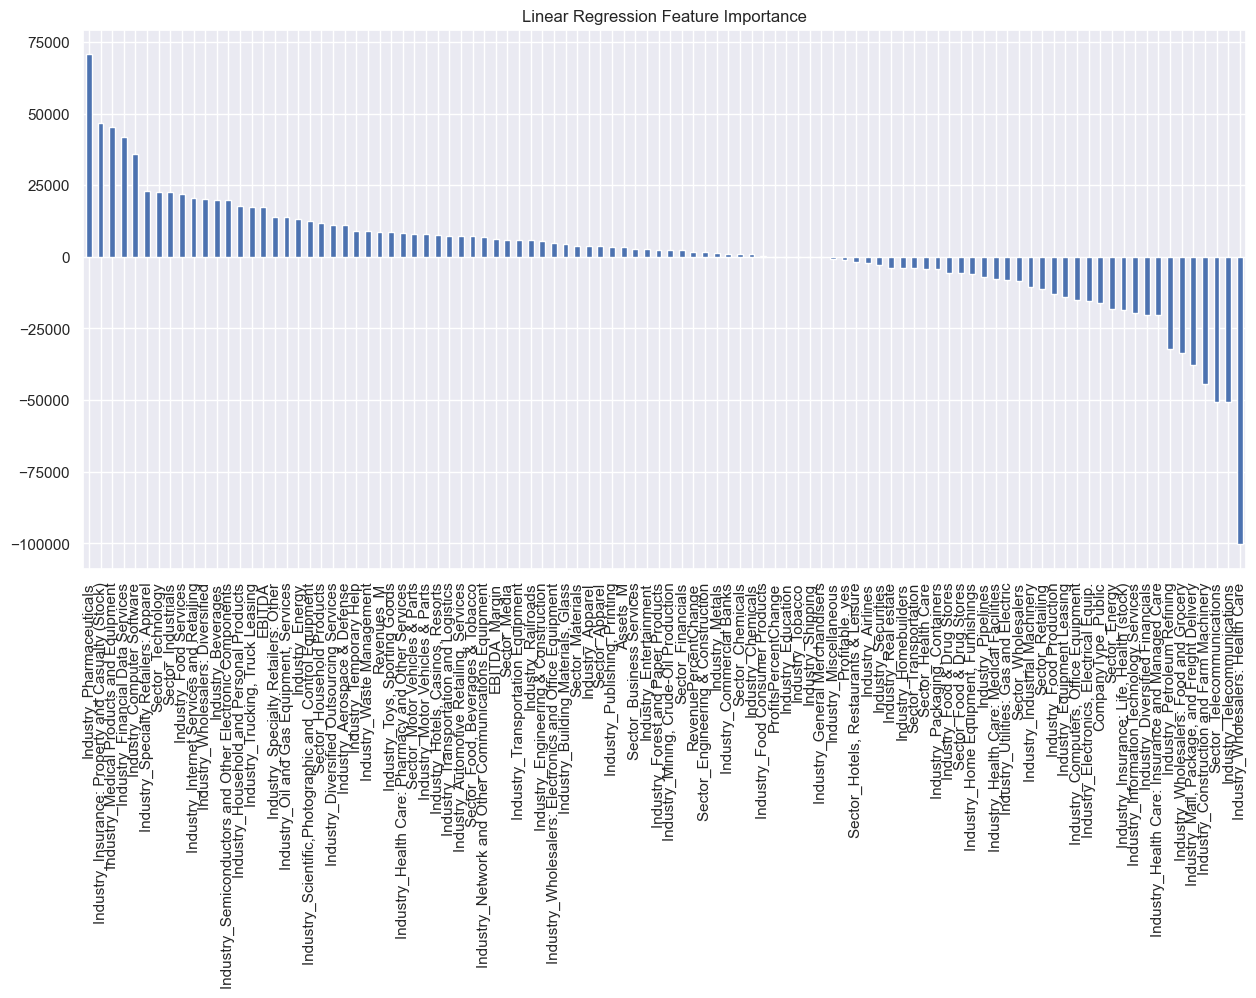

In [591]:
## plot most important features

feature_importance = pd.Series(lr_model.coef_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))

plt.title('Linear Regression Feature Importance')
plt.show()

**Explanation of Feature Importance**

Industry (particularly healthcare-related industries) and certain sectors (e.g., telecommunications) seem to be a significant indication of a company's market cap value. Healthcare tends to grow significantly faster on the basis that pending launches of healthcare drugs will spike market cap severely. 

For instance, during the pandemic, Pfizer's market cap values shot up exponentionally alongside the release of COVID-19-related vaccinations and treatments. As a result, this industry is particularly sensitive to shocks in market cap.

### Part 2: **Ridge Regression**

We will perform Ridge Regression with hyperparameter tuning, and add additional models to analyze results. Lastly, we will evaluate the models. 

In [592]:
ridge = Ridge()

**2.1 Grid Search**

In [593]:
alpha_params = np.logspace(-5, 1, 20)
pipe = GridSearchCV(ridge, param_grid={"alpha": alpha_params}, return_train_score=True, cv=5)
pipe.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01])},
             return_train_score=True)

**Find best scores**

In [594]:
best_score = pipe.best_score_
best_alpha = pipe.best_params_
test_score = pipe.score(X_test, y_test)

print(f"Best score: {best_score}")
print(f"Best alpha: {best_alpha}") 
print(f"Test score: {test_score}")

Best score: 0.6073671377548407
Best alpha: {'alpha': np.float64(10.0)}
Test score: 0.7314836614641853


**Model Interpretation.**

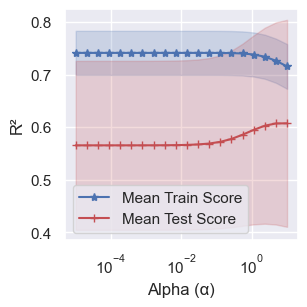

In [595]:
### Plot training and validation R^2 values as a function of alpha
mean_test_score = pipe.cv_results_["mean_test_score"]
std_test_score = pipe.cv_results_["std_test_score"]
mean_train_score = pipe.cv_results_["mean_train_score"]
std_train_score = pipe.cv_results_["std_train_score"]

sns.set()
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1, 1, 1)

# Mean train
plt.plot(alpha_params, mean_train_score, "b*-", label="Mean Train Score")
plt.fill_between(alpha_params, mean_train_score - std_train_score, mean_train_score + std_train_score, color="b", alpha=0.2)

# Mean test
plt.plot(alpha_params, mean_test_score, "r+-", label="Mean Test Score")
plt.fill_between(alpha_params, mean_test_score - std_test_score, mean_test_score + std_test_score, color="r", alpha=0.2)

plt.legend()
ax.set_xscale('log')

# Labels
plt.xlabel("Alpha (α)")
plt.ylabel("R²")

plt.show()

**Updated Ridge Regression model using α=10**

In [596]:
## use best ridge model

best_ridge = Ridge(alpha=10.0)
best_ridge.fit(X_train, y_train)

y_train_pred = best_ridge.predict(X_train)
y_val_pred = best_ridge.predict(X_val)
y_test_pred = best_ridge.predict(X_test)

**RMSE and R² Values**

In [597]:
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training set R²: {train_r2}")
print(f"Validation set R²: {val_r2}")
print(f"Test set R²: {test_r2}")

print(f"Training set RMSE: {train_rmse}")
print(f"Validation set RMSE: {val_rmse}")
print(f"Test set RMSE: {test_rmse}")


Training set R²: 0.7048563699794093
Validation set R²: 0.7163690509671186
Test set R²: 0.7314836614641853
Training set RMSE: 44983.35443433431
Validation set RMSE: 39159.55598668502
Test set RMSE: 48489.21706160448


# III. Neural Network

We will first train a Neural Network that will serve as a baseline. Then, we will integrate dropout and use L2 regularization with another Neural Network. We are using financial data, so we will use dense layers. Additionally, we will use **adam** as the optimizer and experiment with different batch sizes and epochs to determine the best ones.

In [598]:
nn = Sequential()

# input layer
nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  
nn.add(Dropout(0.2)) 

# hidden layer
nn.add(Dense(64, activation='relu'))  
nn.add(Dropout(0.2)) 

# hidden layer
nn.add(Dense(32, activation='relu'))  

# output
nn.add(Dense(1))  

/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile Model**

We use **adam** as the optimizer and we will look at performance using mean squared error.

In [599]:
nn.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_106 (Dense)               │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

**Train the neural network**

We are training the model for 50 epochs.

In [600]:
nn_history_callback = nn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9102716928.0000 - mean_squared_error: 9102716928.0000 - val_loss: 2987226112.0000 - val_mean_squared_error: 2987226112.0000
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 7364783104.0000 - mean_squared_error: 7364783104.0000 - val_loss: 2381746432.0000 - val_mean_squared_error: 2381746432.0000
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 5577041408.0000 - mean_squared_error: 5577041408.0000 - val_loss: 1375740800.0000 - val_mean_squared_error: 1375740800.0000
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5235881472.0000 - mean_squared_error: 5235881472.0000 - val_loss: 1920574592.0000 - val_mean_squared_error: 1920574592.0000
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2907738112.0000 - mean_squared_error: 2907738112.0000 - val_loss: 1100170112.0000 - val_mean_squared_error: 1100170112.0000
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 2638893824.0000 - mean

In [601]:

train_mse = nn_history_callback.history["mean_squared_error"]
train_loss = nn_history_callback.history["loss"]
val_mse = nn_history_callback.history["val_mean_squared_error"]
val_loss = nn_history_callback.history["val_loss"]

for epoch in range(20):
    print(f"Epoch {epoch+1}:\nTrain MSE: {train_mse[epoch]}\nValidation MSE: {val_mse[epoch]}\nTrain Loss: {train_loss[epoch]}\nValidation Loss: {val_loss[epoch]}")

Epoch 1:
Train MSE: 9131167744.0
Validation MSE: 2987226112.0
Train Loss: 9131167744.0
Validation Loss: 2987226112.0
Epoch 2:
Train MSE: 8659521536.0
Validation MSE: 2381746432.0
Train Loss: 8659521536.0
Validation Loss: 2381746432.0
Epoch 3:
Train MSE: 6022671360.0
Validation MSE: 1375740800.0
Train Loss: 6022671360.0
Validation Loss: 1375740800.0
Epoch 4:
Train MSE: 3953202432.0
Validation MSE: 1920574592.0
Train Loss: 3953202432.0
Validation Loss: 1920574592.0
Epoch 5:
Train MSE: 2936193024.0
Validation MSE: 1100170112.0
Train Loss: 2936193024.0
Validation Loss: 1100170112.0
Epoch 6:
Train MSE: 2870824192.0
Validation MSE: 1221800960.0
Train Loss: 2870824192.0
Validation Loss: 1221800960.0
Epoch 7:
Train MSE: 2581085440.0
Validation MSE: 883251264.0
Train Loss: 2581085440.0
Validation Loss: 883251264.0
Epoch 8:
Train MSE: 2596388864.0
Validation MSE: 946066304.0
Train Loss: 2596388864.0
Validation Loss: 946066304.0
Epoch 9:
Train MSE: 2660262400.0
Validation MSE: 784632960.0
Train L

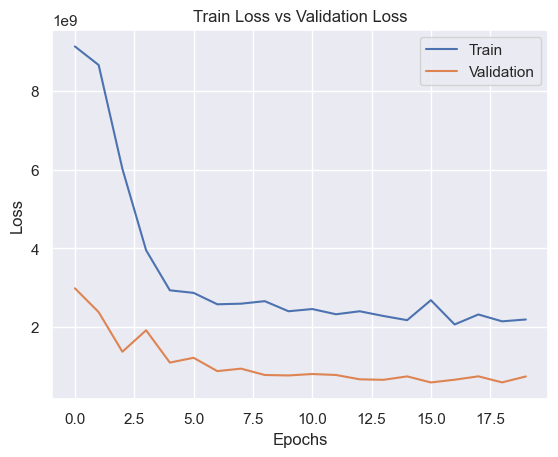

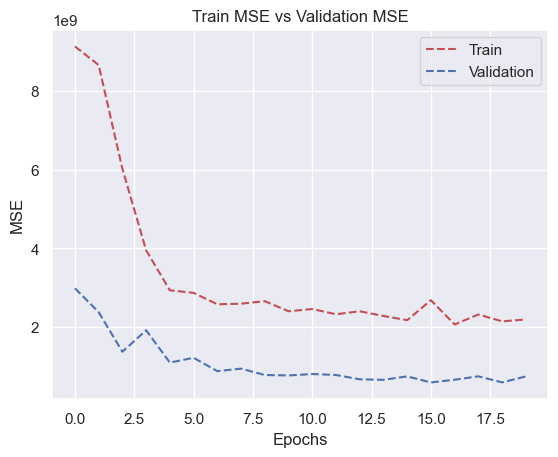

In [602]:
# Plot for train vs. validation loss
nn_hist = pd.DataFrame(nn_history_callback.history)
fig, loss_ax = plt.subplots ()
loss_ax.plot(nn_hist.index, nn_hist["loss"], label="Train")
loss_ax.plot(nn_hist.index, nn_hist["val_loss"], label="Validation")
loss_ax.set_ylabel("Loss")
loss_ax.set_xlabel("Epochs")

loss_ax.legend()

loss_ax.set_title("Train Loss vs Validation Loss")
plt.show()

# Plot for train vs. validation MSE
fig, mse_ax = plt.subplots ()
mse_ax.plot(nn_hist.index, nn_hist["mean_squared_error"], 'r--', label="Train") 
mse_ax.plot(nn_hist.index, nn_hist["val_mean_squared_error"], 'b--', label="Validation")
mse_ax.set_ylabel("MSE")
mse_ax.set_xlabel("Epochs")

mse_ax.legend()

mse_ax.set_title("Train MSE vs Validation MSE")
plt.show()

In [603]:
test_score = nn.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_score[0]:.4f}")

Test Loss: 2442569472.0000


### **L2 Regularization and Dropout Integration with our Neural Network**

Our input shape is the number of features we have in the dataset.

In [604]:
input_shape = (X_train.shape[1],) 

In [605]:
nn_l2_dropout = Sequential()

# hidden layer (with l2 and dropout)
nn_l2_dropout.add(Dense(128, input_shape=input_shape, activation='relu', kernel_regularizer=l2(0.01))) 
nn_l2_dropout.add(Dropout(0.2))  

# hidden layer (with l2 and dropout)
nn_l2_dropout.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
nn_l2_dropout.add(Dropout(0.2)) 

# output
nn_l2_dropout.add(Dense(1))  # No activation because this is regression


/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile New L2 Model**

We use **adam** as the optimizer and we will look at performance using mean squared error.

In [606]:
nn_l2_dropout.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

nn_l2_dropout.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [607]:
l2_dropout_history_callback = nn_l2_dropout.fit(X_train, y_train, batch_size=32, epochs=40, verbose=1, validation_split=0.2) 

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9687226368.0000 - mean_squared_error: 9687226368.0000 - val_loss: 5100138496.0000 - val_mean_squared_error: 5100138496.0000
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8377556992.0000 - mean_squared_error: 8377556992.0000 - val_loss: 5099835904.0000 - val_mean_squared_error: 5099835904.0000
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 9125387264.0000 - mean_squared_error: 9125387264.0000 - val_loss: 5099364352.0000 - val_mean_squared_error: 5099364352.0000
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 8869188608.0000 - mean_squared_error: 8869188608.0000 - val_loss: 5098533376.0000 - val_mean_squared_error: 5098533376.0000
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 8035542016.0000 - mean_squared_error: 8035542016.0000 - val_loss: 5097062400.0000 - val_mean_squared_error: 5097062400.0000
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 10397721600.0000 - mean_

In [608]:
train_mse = l2_dropout_history_callback.history["mean_squared_error"]
train_loss = l2_dropout_history_callback.history["loss"]
val_mse = l2_dropout_history_callback.history["val_mean_squared_error"]
val_loss = l2_dropout_history_callback.history["val_loss"]

for epoch in range(20):
    print(f"Epoch {epoch+1}:\nTrain MSE: {train_mse[epoch]}\nValidation MSE: {val_mse[epoch]}\nTrain Loss: {train_loss[epoch]}\nValidation Loss: {val_loss[epoch]}")

Epoch 1:
Train MSE: 9398409216.0
Validation MSE: 5100138496.0
Train Loss: 9398409216.0
Validation Loss: 5100138496.0
Epoch 2:
Train MSE: 9398045696.0
Validation MSE: 5099835904.0
Train Loss: 9398045696.0
Validation Loss: 5099835904.0
Epoch 3:
Train MSE: 9397580800.0
Validation MSE: 5099364352.0
Train Loss: 9397580800.0
Validation Loss: 5099364352.0
Epoch 4:
Train MSE: 9396729856.0
Validation MSE: 5098533376.0
Train Loss: 9396729856.0
Validation Loss: 5098533376.0
Epoch 5:
Train MSE: 9395244032.0
Validation MSE: 5097062400.0
Train Loss: 9395244032.0
Validation Loss: 5097062400.0
Epoch 6:
Train MSE: 9393112064.0
Validation MSE: 5094673920.0
Train Loss: 9393112064.0
Validation Loss: 5094673920.0
Epoch 7:
Train MSE: 9389317120.0
Validation MSE: 5090988032.0
Train Loss: 9389317120.0
Validation Loss: 5090988032.0
Epoch 8:
Train MSE: 9383629824.0
Validation MSE: 5085507072.0
Train Loss: 9383629824.0
Validation Loss: 5085507072.0
Epoch 9:
Train MSE: 9375068160.0
Validation MSE: 5077473792.0
Tr

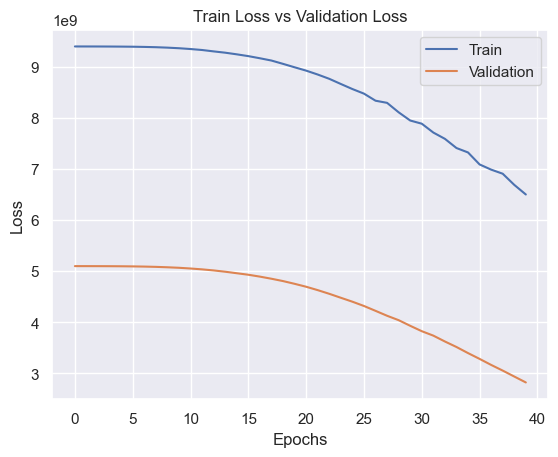

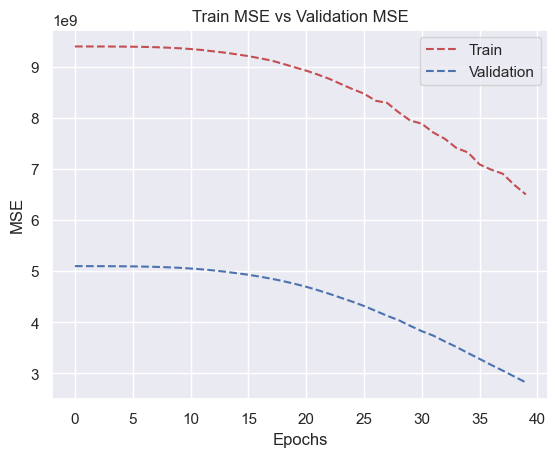

In [609]:
# Plot for train vs. validation loss
l2_dropout_nn_hist = pd.DataFrame(l2_dropout_history_callback.history)
fig, loss_ax = plt.subplots ()
loss_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["loss"], label="Train")
loss_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["val_loss"], label="Validation")
loss_ax.set_ylabel("Loss")
loss_ax.set_xlabel("Epochs")

loss_ax.legend()

loss_ax.set_title("Train Loss vs Validation Loss")
plt.show()

# Plot for train vs. validation MSE
fig, mse_ax = plt.subplots ()
mse_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["mean_squared_error"], 'r--', label="Train") 
mse_ax.plot(l2_dropout_nn_hist.index, l2_dropout_nn_hist["val_mean_squared_error"], 'b--', label="Validation")
mse_ax.set_ylabel("MSE")
mse_ax.set_xlabel("Epochs")

mse_ax.legend()

mse_ax.set_title("Train MSE vs Validation MSE")
plt.show()

**Evaluate model performance on test set**

In [610]:
test_score = nn_l2_dropout.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_score[0]:.4f}")


Test Loss: 6517973504.0000


# IV. Classification

The variable we predicted, Market Cap, is one of several financial metrics that indicate a company's financial outlook. Profitability is one of the more important metrics tied to market capitalization because investors can look for cash flow generation that they assume will be distirbuted to them. Therefore, higher profitability indicates a higher likelihood of dividend distribution that would boost a company's market capitalization. 

For this reason, we chose **profitability** for our classification task. 

### Data Imbalance
These are all Fortune1000 companies, so they will lack sudden market events like bankruptcy and most likely be growing. Therefore, "growth" companies will be the majority class. We will apply stratified splitting (is this needed??) given the imbalanced nature of the dataset and use SMOTE due to this heavy imbalance. 